## Importing the libraries.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from statsmodels.tsa.arima_model import ARIMA
from math import sqrt

import math
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


## Loading APPL Stock Price train and test dataset

In [2]:
data = pd.read_csv('gs.us.txt', sep=',', header=0).fillna(0)
data.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1999-05-04,67.665,68.780,62.329,62.659,24472946,0
1,1999-05-05,62.213,62.213,58.991,61.547,8295140,0
2,1999-05-06,60.542,61.773,59.712,60.488,3185852,0
3,1999-05-07,60.488,66.671,59.429,65.998,5331091,0
4,1999-05-10,65.331,65.441,62.549,62.941,2839054,0


## Visualizing train data

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


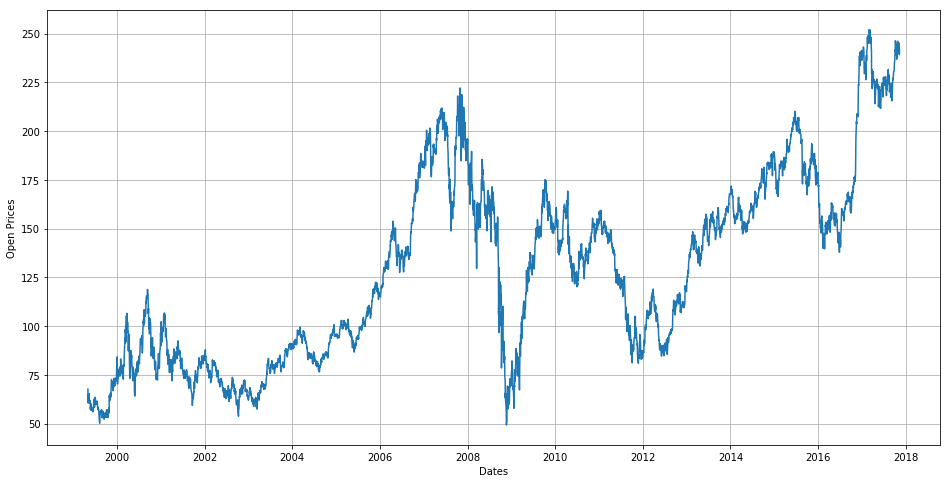

In [3]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('gs.us.txt', sep=',', parse_dates=['Date'], index_col='Date',date_parser=dateparse)
#data = data.loc['2012-11-10':'2017-11-10']
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(data['Open']);

## Plotting autocorrelation

No handles with labels found to put in legend.


          t-1       t+1
t-1  1.000000  0.998288
t+1  0.998288  1.000000


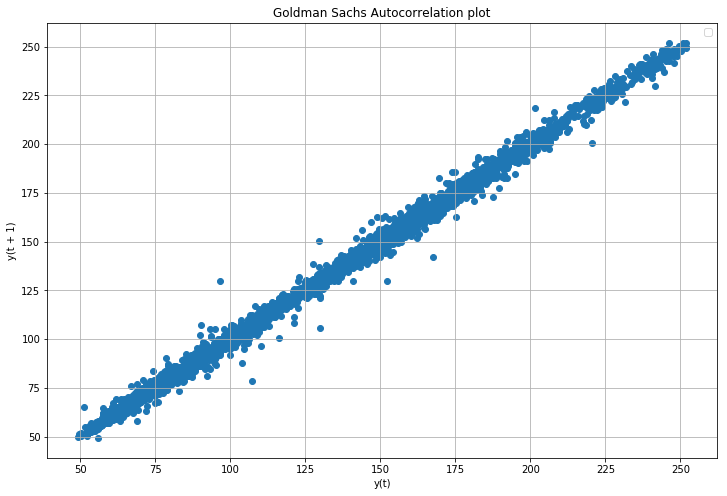

In [4]:
from pandas.plotting import lag_plot
plt.figure(figsize=(12,8))
lag_plot(data['Open'])
plt.title('Goldman Sachs Autocorrelation plot')
plt.grid(True)
plt.legend();

from pandas import DataFrame
from pandas import concat
values = DataFrame(data['Open'].values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

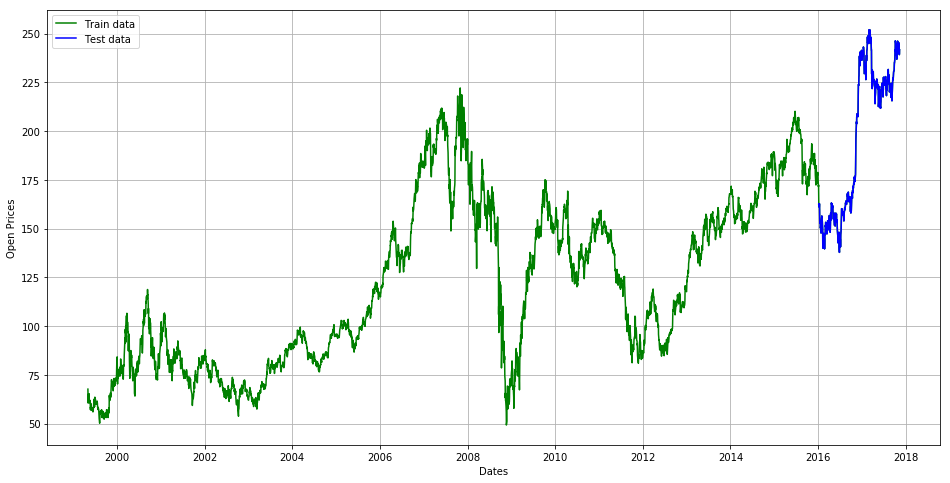

In [5]:
train_data, test_data = data[0:int(len(data)*0.9)], data[int(len(data)*0.9):]
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(data['Open'], 'green', label='Train data')
plt.plot(test_data['Open'], 'blue', label='Test data')
plt.legend()

## Autoregression model

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Lag: 1
MSE: 7.086386735441957
MAE: 2.00747712713399
RMSE: 2.6620268096775352


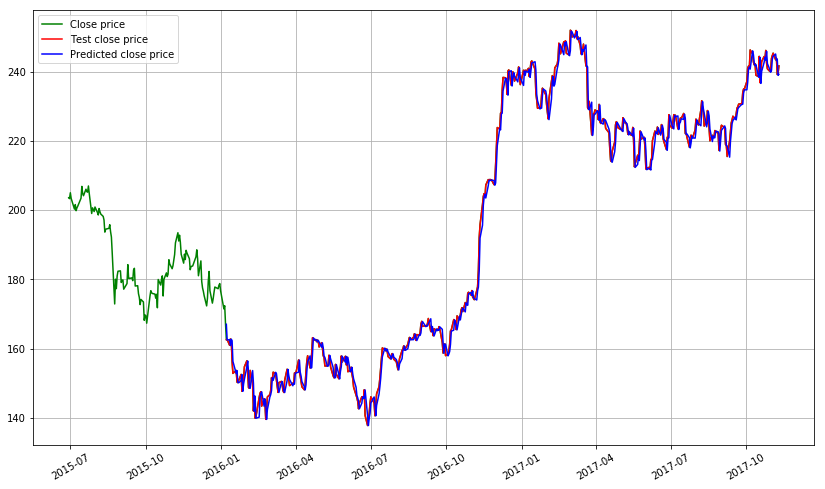

In [6]:
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error

train_ar = train_data['Open']
test_ar = test_data['Open']
# train autoregression
model = AR(train_ar)
model_fit = model.fit(1)
window = model_fit.k_ar
coef = model_fit.params
# walk forward over time steps in test
history = train_ar[len(train_ar)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test_ar)):
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    obs = test_ar[t]
    predictions.append(yhat)
    history.append(obs)
    
plt.figure(figsize=(14,8))
print('Lag: %s' % model_fit.k_ar)
plt.plot(data.index[-600:], data['Open'].tail(600), color='green', label='Close price')
plt.plot(test_data.index, test_data['Open'], color='red', label='Test close price')
plt.plot(test_data.index, predictions, color='blue', label='Predicted close price')
plt.xticks(rotation=30)
plt.grid(True)
plt.legend()

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
mse = mean_squared_error(test_data['Open'], predictions)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data['Open'], predictions)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data['Open'], predictions))
print('RMSE: '+str(rmse))

## ARIMA model

<Figure size 1152x576 with 0 Axes>

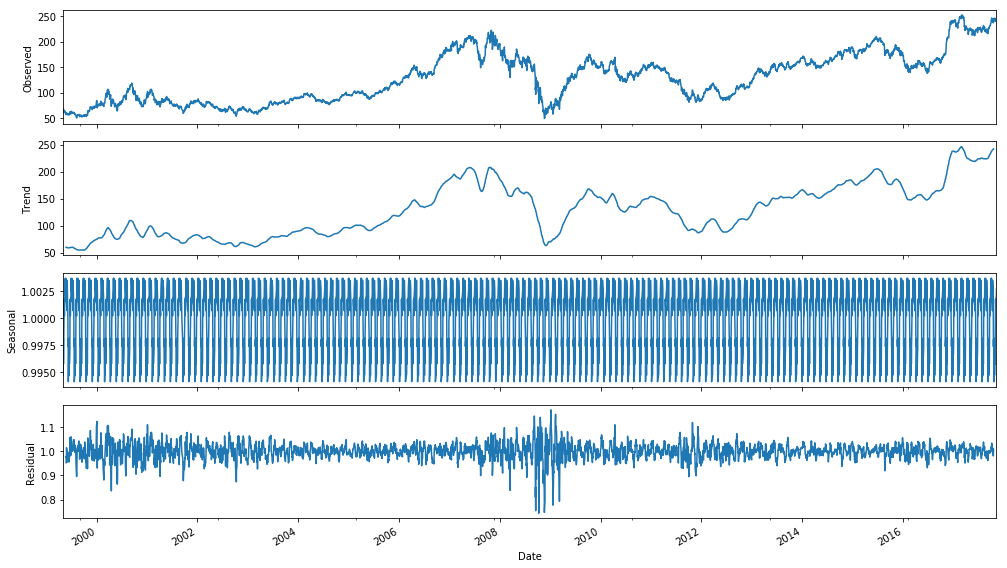

In [7]:
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
data_arima = data['Open']
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data_arima, model='multiplicative', freq=30)
plt.figure(figsize=(16,8))
fig = result.plot()
plt.show()

In [8]:
train_arima = train_data['Open']
test_arima = test_data['Open']

history = [x for x in train_arima]
y = test_arima
# make first prediction
predictions = list()
model = ARIMA(history, order=(2,1,2))
model_fit = model.fit(disp=0)
yhat = model_fit.forecast()[0]
predictions.append(yhat)
history.append(y[0])
# rolling forecasts
for i in range(1, len(y)):
    # predict
    model = ARIMA(history, order=(2,1,2))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    # invert transformed prediction
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)
# report performance
mse = mean_squared_error(y, predictions)
print('MSE: '+str(mse))
mae = mean_absolute_error(y, predictions)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(y, predictions))
print('RMSE: '+str(rmse))

MSE: 7.250101511144478
MAE: 2.028266411129167
RMSE: 2.692601253647572


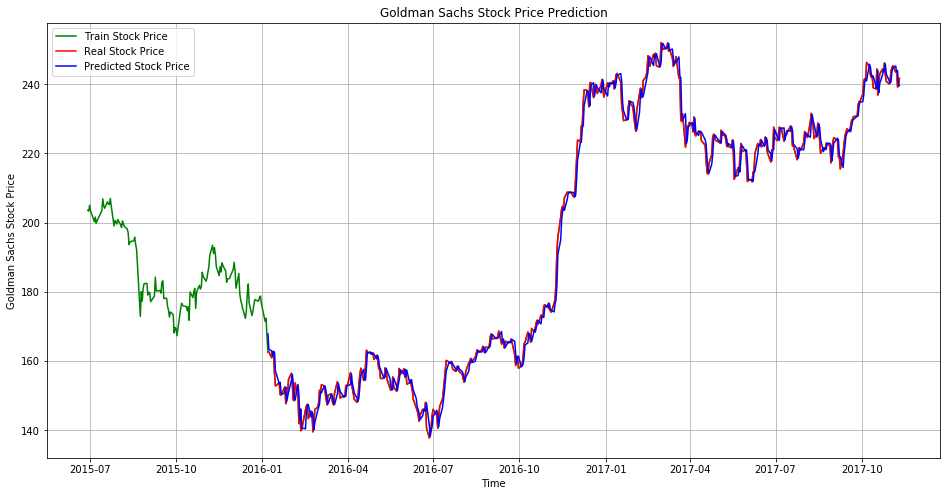

In [9]:
plt.figure(figsize=(16,8))
plt.plot(data.index[-600:], data['Open'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, y, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predictions, color = 'blue', label = 'Predicted Stock Price')
plt.title('Goldman Sachs Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Goldman Sachs Stock Price')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
train = train_data.iloc[:, 0:1].values # selecting open prices

## Feature Scaling

In [11]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train) 

## Now we will creating a data structure with 60 timesteps and 1 output, i.e.Open Stock Price 

In [12]:
timesteps = 30
X_train = []
y_train = []
for i in range(timesteps, train.shape[0]):
    X_train.append(train_scaled[i-timesteps:i, 0]) # we take 60 previous prices
    y_train.append(train_scaled[i, 0]) # and 60-th price as y value
X_train, y_train = np.array(X_train), np.array(y_train)

## Reshaping
*  ### Here second argument is (batch_size, time_step ,input_dim)
* ### batch_size is total number of stock price from 2009-12-31 to 2016, i.e. given by X_train.shape[0]
* ### time_step is total number of previous stock price we want to consider while predicting present stock price, i.e given by X_train.shape[1]
* ### third argument is input_dim-in our case it is 1, i.e.Open price, but it can be more than one. It basically includes all those factors/indicators that can affect present stock price 

In [13]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

## Building the RNN

In [34]:
model = Sequential()

# Adding the first LSTM layer 
# Here return_sequences=True means whether to return the last output in the output sequence, or the full sequence.
# it basically tells us that there is another(or more) LSTM layer ahead in the network.
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
# Dropout regularisation for tackling overfitting
model.add(Dropout(0.20))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.25))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.25))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
# RMSprop is a recommended optimizer as per keras documentation
# check out https://keras.io/optimizers/ for more details
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
4164/4164 [==============================] - 15s 4ms/step - loss: 0.0151
Epoch 2/50
4164/4164 [==============================] - 12s 3ms/step - loss: 0.0045
Epoch 3/50
4164/4164 [==============================] - 13s 3ms/step - loss: 0.0041
Epoch 4/50
4164/4164 [==============================] - 12s 3ms/step - loss: 0.0037
Epoch 5/50
4164/4164 [==============================] - 12s 3ms/step - loss: 0.0036
Epoch 6/50
4164/4164 [==============================] - 12s 3ms/step - loss: 0.0030
Epoch 7/50
4164/4164 [==============================] - 12s 3ms/step - loss: 0.0029
Epoch 8/50
4164/4164 [==============================] - 12s 3ms/step - loss: 0.0028
Epoch 9/50
4164/4164 [==============================] - 13s 3ms/step - loss: 0.0024
Epoch 10/50
4164/4164 [==============================] - 12s 3ms/step - loss: 0.0024
Epoch 11/50
4164/4164 [==============================] - 12s 3ms/step - loss: 0.0024
Epoch 12/50
4164/4164 [==============================] - 12s 3ms/step - lo

## Now making the predictions and visualising the results

In [35]:
# this will be used later while comparing and visualization
real_stock_price = test_data.iloc[:,0:1].values # taking open price

In [36]:
# combine original train and test data vertically
# as previous Open Prices are not present in test dataset
# e.g. for predicting Open price for first date in test data, we will need stock open prices on timesteps previous dates  
combine = pd.concat((train_data['Open'], test_data['Open']), axis = 0)
# our test inputs also contains stock open Prices of last timesteps dates (as described above)
test_inputs = combine[len(combine) - len(test_data) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)

In [37]:
test_data.shape

(467, 6)

In [38]:
# same steps as we followed while processing training data
X_test = []
for i in range(timesteps, test_data.shape[0]+timesteps):
    X_test.append(test_inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
# inverse_transform because prediction is done on scaled inputs
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

## Visualising the results

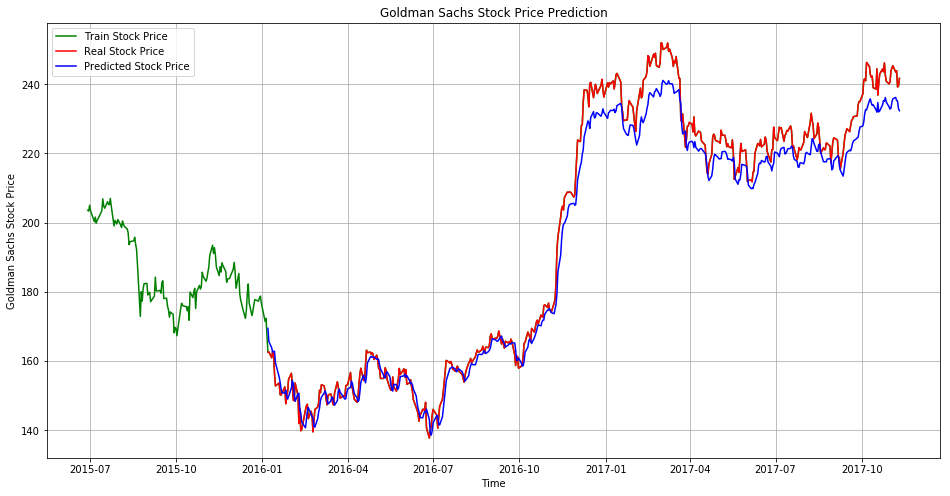

MSE: 31.00482165740853
MAE: 4.466198207683687
RMSE: 5.568197343612072


In [39]:
plt.figure(figsize=(16,8))
plt.plot(data.index[-600:], data['Open'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Goldman Sachs Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Goldman Sachs Stock Price')
plt.legend()
plt.grid(True)
plt.show()

mse = mean_squared_error(real_stock_price, predicted_stock_price)
print('MSE: '+str(mse))
mae = mean_absolute_error(real_stock_price, predicted_stock_price)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print('RMSE: '+str(rmse))